In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import os
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2 as  PretrainedModel,preprocess_input

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image

In [3]:
# import zipfile



# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/dataset/archive (2).zip", 'r')
# zip_ref.extractall("/content/drive/MyDrive/dataset/")
# zip_ref.close()

In [4]:
base_dir= "/content/drive/MyDrive/dataset/TB_Chest_Radiography_Database"
os.listdir(base_dir)

['Normal.metadata.xlsx',
 'Normal',
 'README.md.txt',
 'Tuberculosis.metadata.xlsx',
 'Tuberculosis']

In [5]:
tuberculosis_data= "/content/drive/MyDrive/dataset/TB_Chest_Radiography_Database/Tuberculosis"
print("tuberculosis images :\n" ,os.listdir(tuberculosis_data)[:5])

normal_data= "/content/drive/MyDrive/dataset/TB_Chest_Radiography_Database/Normal"
print("\nnormal images :\n" ,os.listdir(normal_data)[:5])

tuberculosis images :
 ['Tuberculosis-1.png', 'Tuberculosis-10.png', 'Tuberculosis-100.png', 'Tuberculosis-101.png', 'Tuberculosis-102.png']

normal images :
 ['Normal-1.png', 'Normal-10.png', 'Normal-100.png', 'Normal-1000.png', 'Normal-1001.png']


In [6]:
print("no. of tuberculosis images :" ,len(os.listdir(tuberculosis_data)))
print("\nno. of normal images :" ,len(os.listdir(normal_data)))

no. of tuberculosis images : 700

no. of normal images : 3500


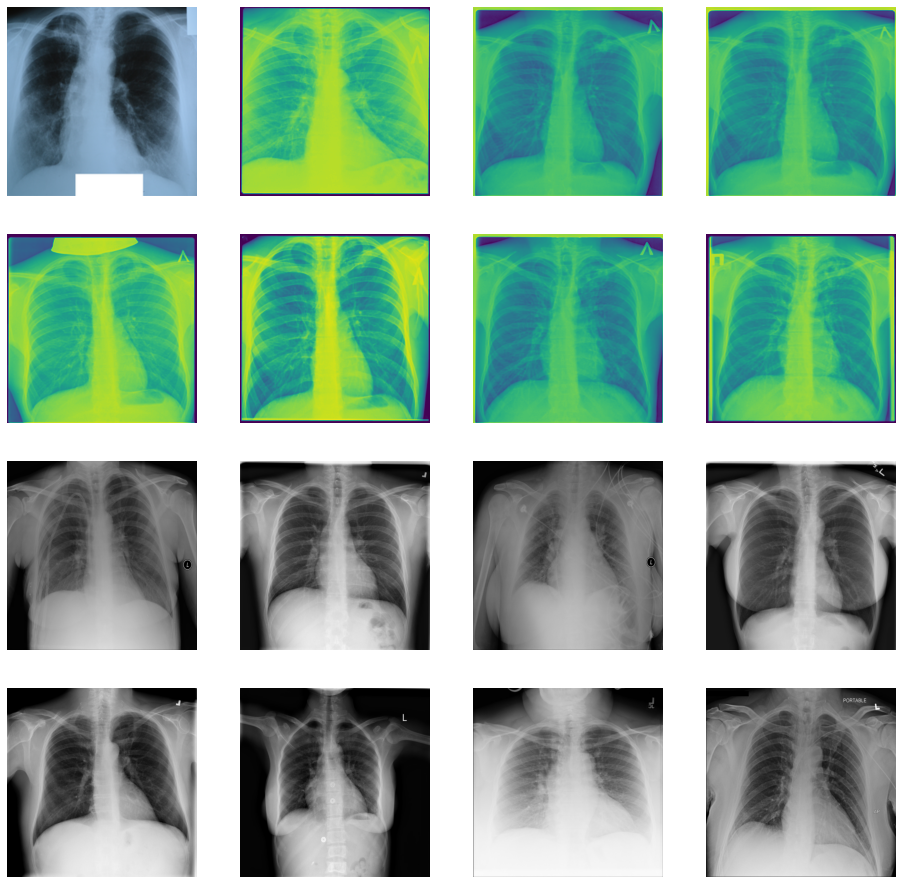

In [7]:
nrows= 4
ncols= 4
pic_index= 0

fig= plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index+=8

tuberculosis_img = [os.path.join(tuberculosis_data, image) for image in os.listdir(tuberculosis_data)[pic_index-8:pic_index]]
normal_img = [os.path.join(normal_data, image) for image in os.listdir(normal_data)[pic_index-8:pic_index]]

for i, image_path in enumerate(tuberculosis_img+normal_img):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') 

    img = mpimg.imread(image_path)
    plt.imshow(img)

plt.show()

In [8]:
image= imread("/content/drive/MyDrive/dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-10.png")
image.shape

(512, 512)

In [9]:
print("training data :")
train_datagen= ImageDataGenerator(rescale=1/255, zoom_range=0.3, rotation_range=50, width_shift_range= 0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest', validation_split = 0.2)

train_data = train_datagen.flow_from_directory(base_dir, 
                                              target_size= (300, 300),
                                              class_mode= "binary",
                                              batch_size=20,
                                              subset= "training"
                                              )

print("\nvalidation data :")
val_datagen= ImageDataGenerator(rescale= 1/255, validation_split= 0.2)

val_data= train_datagen.flow_from_directory(base_dir, 
                                              target_size= (300, 300),
                                              class_mode= "binary",
                                              batch_size=20,
                                              shuffle= False,
                                              subset= "validation"
                                              )

training data :
Found 3360 images belonging to 2 classes.

validation data :
Found 840 images belonging to 2 classes.


In [10]:
train_data.class_indices

{'Normal': 0, 'Tuberculosis': 1}

In [11]:

inception_resnet= PretrainedModel(input_shape= (300, 300,3), include_top= False, weights="imagenet")

last_output= inception_resnet.layers[-1].output
last_output= Flatten()(last_output)
pretrained_model= Model(inception_resnet.input, last_output)    

219070464/219055592 [==============================] - 5s 0us/step


In [12]:
pretrained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [13]:

x= Dense(units=512, activation="relu")(last_output)
x=Dropout(0.2)(x)

x= Dense(units=128, activation="relu")(x)
x=Dropout(0.2)(x)

x= Dense(units=1, activation="sigmoid")(x)

model= Model(pretrained_model.input, x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [14]:
train_data.samples//train_data.batch_size

168

In [15]:
val_data.samples//val_data.batch_size

42

In [16]:
model.compile(loss="binary_crossentropy", optimizer=optimizers.RMSprop(lr=1e-4), metrics=["accuracy"])

for layer in pretrained_model.layers:
    layer.trainable= False


history= model.fit(train_data,
                   steps_per_epoch= train_data.samples//train_data.batch_size,
                   validation_data= val_data,
                   validation_steps= val_data.samples//val_data.batch_size,
                   epochs= 10,
                   verbose=2 
                  )



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/10
168/168 - 221s - loss: 0.2147 - accuracy: 0.9500 - val_loss: 35.4399 - val_accuracy: 0.8357 - 221s/epoch - 1s/step
Epoch 2/10
168/168 - 159s - loss: 0.0736 - accuracy: 0.9848 - val_loss: 1273.9200 - val_accuracy: 0.8679 - 159s/epoch - 947ms/step
Epoch 3/10
168/168 - 157s - loss: 0.0419 - accuracy: 0.9869 - val_loss: 4.9163 - val_accuracy: 0.9774 - 157s/epoch - 933ms/step
Epoch 4/10
168/168 - 158s - loss: 0.0324 - accuracy: 0.9902 - val_loss: 0.0639 - val_accuracy: 0.9940 - 158s/epoch - 938ms/step
Epoch 5/10
168/168 - 156s - loss: 0.0369 - accuracy: 0.9914 - val_loss: 0.0611 - val_accuracy: 0.9976 - 156s/epoch - 931ms/step
Epoch 6/10
168/168 - 158s - loss: 0.0201 - accuracy: 0.9949 - val_loss: 0.0029 - val_accuracy: 0.9988 - 158s/epoch - 939ms/step
Epoch 7/10
168/168 - 157s - loss: 0.0199 - accuracy: 0.9946 - val_loss: 6.6478 - val_accuracy: 0.9845 - 157s/epoch - 936ms/step
Epoch 8/10
168/168 - 156s - loss: 0.0277 - accuracy: 0.9937 - val_loss: 11.7156 - val_accuracy: 0.9833 

TypeError: ignored

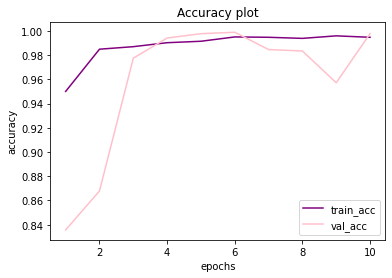

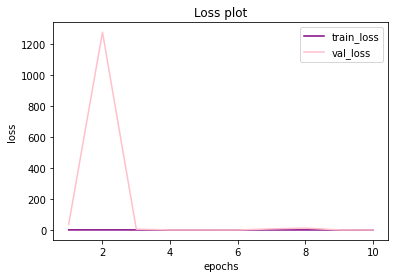

In [31]:


history.history.keys()

epochs= range(1, len(history.history["accuracy"])+1)

plt.plot(epochs, history.history["accuracy"], color="purple")
plt.plot(epochs, history.history["val_accuracy"], color="pink")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy plot")
plt.legend(["train_acc", "val_acc"])
plt.show()

plt.plot(epochs, history.history["loss"], color="purple")
plt.plot(epochs, history.history["val_loss"], color="pink")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss plot")
plt.legend(["train_loss", "val_loss"])
plt.show()

In [17]:
model.save("/content/drive/MyDrive/dataset/tuber.h5")

In [18]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/dataset/tuber.h5')
model.summary()
print('Model loaded')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [19]:
train_datagen.flow_from_directory

<bound method ImageDataGenerator.flow_from_directory of <keras.preprocessing.image.ImageDataGenerator object at 0x7f9f50e94ed0>>

In [23]:
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
filepath="/content/drive/MyDrive/dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-1.png"
filepath2="TB_Chest_Radiography_Database/Normal/Normal-88.png"
# img = Image.open(io.BytesIO(img))
img = image.load_img(filepath, target_size=(300, 300))
img = image.img_to_array(img)
img = np.asarray(img)/255
img = np.expand_dims(img, axis=0)

pred = model.predict(img)

print(pred)

if (pred[0]>0.5):
    print("tuber detected")
else:
    print("no tubor")


# prediction= model.predict(val_data)
# prediction= (prediction > 0.5)
# prediction

[[1.]]
tuber detected


In [24]:
prediction= model.predict(val_data, steps=np.ceil(val_data.samples/val_data.batch_size), verbose=2)
prediction= (prediction > 0.5)

42/42 - 29s - 29s/epoch - 695ms/step


In [25]:
val_labels=val_data.classes

In [26]:
prediction.shape

(840, 1)

In [27]:
val_labels.shape

(840,)

0.9976190476190476
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       700
           1       1.00      0.99      0.99       140

    accuracy                           1.00       840
   macro avg       1.00      0.99      1.00       840
weighted avg       1.00      1.00      1.00       840



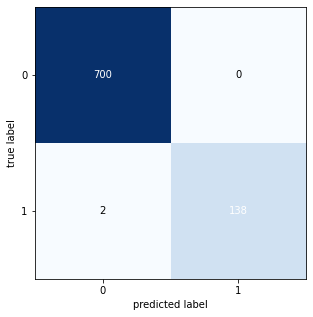

In [28]:
cm= confusion_matrix(val_data.classes, prediction)
plot_confusion_matrix(cm, figsize=(5,5))

print(accuracy_score(val_data.classes, prediction))

print(classification_report(val_data.classes, prediction))

# from sklearn.metrics import precision_recall_fscore_support as score

# precision,recall,fscore,support=score(val_data.classes, prediction)
# print('Precision : {}'.format(precision))
# print ('Recall    : {}'.format(recall))
# print ('F-score   : {}'.format(fscore))



